http://psh01com1hcom02:8885/tree?token=6b16ccaa3c414baf40fefa8b99b56a0132cb81aae64d0542

In [122]:
import os, sys, json, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import pearsonr
from datetime import datetime
import seaborn

PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
DEV_DIR     = os.path.join(PROJECT_DIR, "dev/transformer")

sys.path.append(DEV_DIR)

from transformer import MultiomicTransformer
from transformer_dataset import MultiomicTransformerDataset
from transformer_training import prepare_dataloader
import eval

SAMPLE_NAME = "mESC"
CHROM_ID    = "chr19"
TRAINING_RUN_NAME = "model_training_01_10_16_03_45"

TRANSFORMER_DATA_DIR = os.path.join(DEV_DIR, f"transformer_data/{SAMPLE_NAME}")
COMMON_DIR           = os.path.join(DEV_DIR, "transformer_data/common")
OUTPUT_DIR           = os.path.join(PROJECT_DIR, "output/transformer_testing_output")

TEST_DIR             = os.path.join(OUTPUT_DIR, f"{SAMPLE_NAME}/{CHROM_ID}/{TRAINING_RUN_NAME}")  # where checkpoint lives

GROUND_TRUTH_DIR = os.path.join(PROJECT_DIR, "ground_truth_files")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH  = 32
TG_CHUNK = 64 

training_log_file = os.path.join(TEST_DIR, "training_log.csv")
training_log_df = pd.read_csv(training_log_file, header=0, index_col=0)

In [102]:
def load_model_and_data():
    # --- run params ---
    with open(os.path.join(TEST_DIR, "run_parameters.json")) as f:
        run_params = json.load(f)

    d_model   = run_params["d_model"]
    n_heads   = run_params["Attention Heads"]
    n_layers  = run_params["Model Layers"]
    d_ff      = run_params["d_feedforward"]
    dropout   = run_params["Dropout"]
    model_pt  = os.path.join(TEST_DIR, "checkpoint.pt")

    # --- dataset ---
    dataset = MultiomicTransformerDataset(
        data_dir=TRANSFORMER_DATA_DIR,
        chrom_id=CHROM_ID,
        tf_vocab_path=os.path.join(COMMON_DIR, "tf_vocab.json"),
        tg_vocab_path=os.path.join(COMMON_DIR, "tg_vocab.json"),
    )
    train_loader, _, test_loader = prepare_dataloader(dataset, batch_size=BATCH, world_size=1, rank=0)

    # --- model ---
    # infer whether shortcut existed in checkpoint
    sd = torch.load(model_pt, map_location=DEVICE)
    use_shortcut = run_params.get("Shortcut L1", None) is not None

    model = MultiomicTransformer(
        d_model=d_model, num_heads=n_heads, num_layers=n_layers,
        d_ff=d_ff, dropout=dropout,
        tf_vocab_size=len(dataset.tf_name2id),
        tg_vocab_size=len(dataset.tg_name2id),
        use_shortcut=use_shortcut,
        use_motif_mask=run_params.get("Motif Mask", "No") == "Yes",
        lambda_l1=run_params.get("Shortcut L1", 0.0),
        lambda_l2=run_params.get("Shortcut L2", 0.0),
        topk=run_params.get("Shortcut Top K", None),
        shortcut_dropout=run_params.get("Shortcut Dropout", 0.0)
    ).to(DEVICE)
    model.load_state_dict(sd, strict=True)
    model.eval()

    return model, dataset, train_loader, test_loader

model, dataset, train_loader, test_loader = load_model_and_data()

scaler_path = os.path.join(TEST_DIR, "tg_scaler.pkl")
scaler = joblib.load(scaler_path)

In [103]:
# Load your TF→TG attention matrix
attn_df = pd.read_csv(os.path.join(TEST_DIR, "tf_tg_mean_attention.csv"), index_col=0)

# Incoming attention per TG (mean across TFs)
tg_incoming = attn_df.mean(axis=1) 
tg_incoming.index = dataset.tg_names

def per_gene_correlation(model, dataloader, device="cuda:0", gene_names=None):
    model.eval()
    preds, tgts = [], []

    with torch.no_grad():
        for atac_wins, tf_tensor, tg_true, bias, tf_ids, tg_ids, motif_mask in dataloader:
            atac_wins, tf_tensor, tg_true, bias = (
                atac_wins.to(device), tf_tensor.to(device),
                tg_true.to(device), bias.to(device)
            )
            if tf_ids is not None: tf_ids = tf_ids.to(device)
            if tg_ids is not None: tg_ids = tg_ids.to(device)

            out, _ = model(atac_wins, tf_tensor, tf_ids=tf_ids, tg_ids=tg_ids,
                        bias=bias, motif_mask=motif_mask)
            
            preds.append(out.detach().cpu().numpy())
            tgts.append(tg_true.detach().cpu().numpy())

    import numpy as np
    preds = np.concatenate(preds, axis=0)
    tgts  = np.concatenate(tgts, axis=0)

    results = []
    for i, g in enumerate(gene_names):
        if np.std(tgts[:, i]) < 1e-8:
            results.append((g, None))
        else:
            corr, _ = pearsonr(preds[:, i], tgts[:, i])
            results.append((g, corr))

    return pd.DataFrame(results, columns=["gene", "pearson"])

corr_df = per_gene_correlation(model, test_loader, device=DEVICE, gene_names=dataset.tg_names)

# Merge with incoming attention
merged = corr_df.merge(tg_incoming.rename("mean_incoming_attention"),
                       left_on="gene", right_index=True)

print(merged)

/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              gene   pearson  mean_incoming_attention
0    1110059E24Rik  0.288167                 0.003817
1    1700028P14Rik  0.847407                 0.003817
2    1700054A03Rik  0.175939                 0.003817
3    4430402I18Rik  0.673758                 0.003817
4    4930414N06Rik  0.302523                 0.003817
..             ...       ...                      ...
241          Vti1a  0.677761                 0.003817
242           Vwa2  0.623013                 0.003817
243          Wnt8b  0.759524                 0.003817
244          Yif1a  0.433042                 0.003817
245         Zfand5  0.544405                 0.003817

[246 rows x 3 columns]


In [116]:
@torch.no_grad()
def extract_shortcut_matrix(model, dataset, device="cpu", normalize="global"):
    """
    Runs a dummy forward to pull out the TF→TG attention (shortcut) matrix.
    Returns DataFrame [TF × TG].
    """
    model.eval()
    
    # Build dummy inputs
    B = 1
    W = 1
    atac_windows = torch.zeros(B, W, 1, device=device)      # minimal fake ATAC
    tf_expr = torch.zeros(B, len(dataset.tf_names), device=device)  # fake TF expression
    tf_ids = torch.arange(len(dataset.tf_names), device=device)
    tg_ids = torch.arange(len(dataset.tg_names), device=device)
    
    # Forward once
    logits, attn = model(
        atac_windows, tf_expr, tf_ids, tg_ids, 
        bias=None, motif_mask=None
    )
    
    # attn is [G, T], transpose to [T, G]
    mat = attn.detach().cpu().T
    
    # Apply scale
    mat = model.shortcut_layer.scale.item() * mat
    
    # Normalize if requested
    if normalize == "global":
        mn, mx = mat.min(), mat.max()
        mat = (mat - mn) / (mx - mn + 1e-8)
    elif normalize == "per_tg":
        mn = mat.min(dim=0, keepdim=True).values
        mx = mat.max(dim=0, keepdim=True).values
        mat = (mat - mn) / (mx - mn + 1e-8)
    
    import pandas as pd
    return pd.DataFrame(
        mat.numpy(),
        index=dataset.tf_names,
        columns=dataset.tg_names
    )

print("\nExtracting shortcut TF×TG matrix (no gradients needed)")
tf_importance_df = extract_shortcut_matrix(model, dataset, normalize="global")
tf_importance_df.index = tf_importance_df.index.str.capitalize()
print(tf_importance_df.head())

out_csv = os.path.join(TEST_DIR, "tf_tg_shortcut_matrix.csv")
tf_importance_df.to_csv(out_csv)
print(f"Saved TF→TG shortcut matrix: {out_csv}, shape={tf_importance_df.shape}")


Extracting shortcut TF×TG matrix (no gradients needed)
       1110059E24Rik  1700028P14Rik  1700054A03Rik  4430402I18Rik  \
Amyb        0.063616       0.017516       0.003541       0.008445   
Ap-1        0.107908       0.006301       0.028623       0.003855   
Atoh1       0.008607       0.006714       0.033538       0.068808   
Hnf4a       0.006869       0.002154       0.021999       0.008363   
Hnf6        0.010341       0.019525       0.003990       0.039449   

       4930414N06Rik  4930481A15Rik  4930505N22Rik      A1cf  A330040F15Rik  \
Amyb        0.002334       0.051914       0.046596  0.004771       0.015869   
Ap-1        0.016407       0.017766       0.052344  0.004209       0.008391   
Atoh1       0.027414       0.020588       0.006851  0.008397       0.008645   
Hnf4a       0.031129       0.007510       0.016900  0.019261       0.012585   
Hnf6        0.019196       0.030140       0.012007  0.012098       0.012595   

       A930007I19Rik  ...     Trpt1  Tsga10ip   Unc93b

In [117]:
beeline_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "mESC_beeline_ChIP-seq.csv"))
beeline_ground_truth = beeline_ground_truth.rename(columns={"Gene1":"TF", "Gene2":"TG"})

orti_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "mESC_beeline_ChIP-seq.csv"))
orti_ground_truth = orti_ground_truth.rename(columns={"Gene1":"TF", "Gene2":"TG"})

rn115_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "rn115_chipseq.tsv"), sep="\t")
rn115_ground_truth = rn115_ground_truth.rename(columns={"sourceName":"TF", "targetName":"TG"})
rn115_ground_truth = rn115_ground_truth[["TF", "TG"]]

In [144]:
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate_chip_aucs_balanced(tf_importance_df, chip, k_list=(100, 500, 1000, 5000), seed=0):
    rng = np.random.default_rng(seed)
    
    chip_edges = {(t.upper(), g.upper()) for t, g in zip(chip["TF"], chip["TG"])}

    tf_imp = tf_importance_df.copy()
    tf_imp.index   = [x.upper() for x in tf_imp.index]
    tf_imp.columns = [x.upper() for x in tf_imp.columns]

    rn111_tfs = {t for t, _ in chip_edges}
    rn111_tgs = {g for _, g in chip_edges}
    tf_imp = tf_imp.loc[tf_imp.index.intersection(rn111_tfs),
                        tf_imp.columns.intersection(rn111_tgs)]

    scores, labels, edges = [], [], []
    for tg in tf_imp.columns:
        for tf, score in tf_imp[tg].items():
            scores.append(float(score))
            labels.append(1 if (tf, tg) in chip_edges else 0)
            edges.append((tf, tg))

    df_scored = pd.DataFrame(edges, columns=["tf", "tg"])
    df_scored["score"] = scores
    df_scored["label"] = labels

    # --- Balance positives and negatives ---
    pos_df = df_scored[df_scored["label"] == 1]
    neg_df = df_scored[df_scored["label"] == 0]

    n_min = min(len(pos_df), len(neg_df))
    pos_df = pos_df.sample(n=n_min, random_state=seed)
    neg_df = neg_df.sample(n=n_min, random_state=seed)

    df_balanced = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=seed).reset_index(drop=True)

    results = {}
    # Global balanced metrics
    results["AUROC_balanced"] = roc_auc_score(df_balanced["label"], df_balanced["score"])
    results["PR-AUC_balanced"] = average_precision_score(df_balanced["label"], df_balanced["score"])

    # Top-k metrics (on balanced set)
    df_balanced = df_balanced.sort_values("score", ascending=False).reset_index(drop=True)
    for k in k_list:
        if k <= len(df_balanced):
            subset = df_balanced.head(k)
            if subset["label"].nunique() > 1:
                results[f"AUROC@{k}"] = roc_auc_score(subset["label"], subset["score"])
                results[f"PR-AUC@{k}"] = average_precision_score(subset["label"], subset["score"])
            results[f"Precision@{k}"] = subset["label"].mean()

    return results, df_balanced

ground_truth_sets = [beeline_ground_truth, rn115_ground_truth, orti_ground_truth]

results, scored_edges = evaluate_chip_aucs_balanced(
    tf_importance_df,
    orti_ground_truth,
    k_list=(50, 100, 500, 1000, 5000)
)

print("Shortcut evaluation:")
print(f"AUROC = {results['AUROC_balanced']:.4f}")
print(f"PR-AUC = {results['PR-AUC_balanced']:.4f}")
for k in (50, 100, 500, 1000, 5000):
    if f'AUROC@{k}' in results:
        print(f"AUROC@{k}: {results[f'AUROC@{k}']:.3f}")


Shortcut evaluation:
AUROC = 0.5165
PR-AUC = 0.5194
AUROC@50: 0.519
AUROC@100: 0.591
AUROC@500: 0.524
AUROC@1000: 0.511


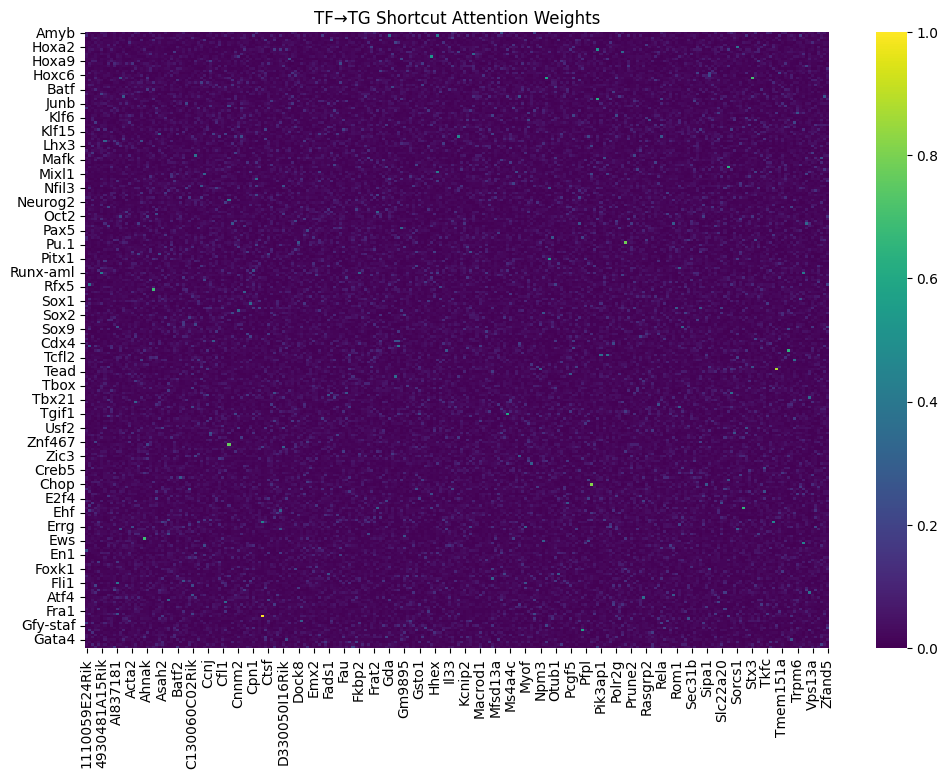

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(tf_importance_df, cmap="viridis", vmin=0, vmax=1)
plt.title("TF→TG Shortcut Attention Weights")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd

def evaluate_on_dev_set_balanced(tf_importance_df, dev_edges, seed=0):
    rng = np.random.default_rng(seed)

    # Normalize names
    tf_imp = tf_importance_df.copy()
    tf_imp.index   = [x.upper() for x in tf_imp.index]
    tf_imp.columns = [x.upper() for x in tf_imp.columns]
    dev_edges = {(tf.upper(), tg.upper()) for tf, tg in dev_edges}

    # Collect positives
    positives = []
    for tf, tg in dev_edges:
        if tf in tf_imp.index and tg in tf_imp.columns:
            positives.append((tf, tg, tf_imp.loc[tf, tg]))

    n_pos = len(positives)
    if n_pos == 0:
        raise ValueError("No positives found in tf_importance_df.")

    # Sample negatives (same number as positives)
    all_tfs, all_tgs = list(tf_imp.index), list(tf_imp.columns)
    neg_edges = set()
    while len(neg_edges) < n_pos:
        tf, tg = rng.choice(all_tfs), rng.choice(all_tgs)
        if (tf, tg) not in dev_edges:
            neg_edges.add((tf, tg))

    negatives = [(tf, tg, tf_imp.loc[tf, tg]) for (tf, tg) in neg_edges]

    # Combine
    df = pd.DataFrame(
        positives + negatives,
        columns=["TF", "TG", "score"]
    )
    df["label"] = [1]*n_pos + [0]*n_pos

    # Metrics
    auroc = roc_auc_score(df["label"], df["score"])
    auprc = average_precision_score(df["label"], df["score"])

    return auroc, auprc, df.sort_values("score", ascending=False).reset_index(drop=True)


dev_edges = {
    ("Pou5f1", "Nanog"),
    ("Sox2", "Nanog"),
    ("Nanog", "Pou5f1"),
    ("Nanog", "Sox2"),
    ("Pou5f1", "Sox2"),
    ("Sox2", "Pou5f1"),
    ("Pou5f1", "Esrrb"),
    ("Nanog", "Esrrb"),
    ("Tcf3", "Esrrb"),
    ("Otx2", "Pou5f1"),
    ("Otx2", "Sox2"),
    ("Esrrb", "Nanog"),
    ("Esrrb", "Pou5f1"),
    ("Gata6", "Sox17"),    # primitive endoderm program
    ("Gata6", "Gata4"),    # endoderm initiation
    ("Gata4", "Sox17"),    # downstream enhancer activation
    ("Cdx2", "Gata6"),     # trophectoderm vs ICM
    ("Cdx2", "Eomes"),     # trophoblast differentiation
    ("Eomes", "Mixl1"),    # mesendoderm specification
    ("Sox17", "Foxa2"),    # definitive endoderm
    ("Klf4", "Pou5f1"),    # pluripotency–differentiation interface
    
}

auroc, auprc, curated_imp_df = evaluate_on_dev_set_balanced(tf_importance_df, dev_edges)

print("AUROC:", auroc, "AUPRC:", auprc)
print(curated_imp_df)

ValueError: No positives found in tf_importance_df (name mismatch).

In [125]:
grad_df = pd.read_csv(os.path.join(TEST_DIR, "tf_gradient_attributions/tf_importance_matrix.csv"), index_col=0)
common_tfs = tf_importance_df.index.intersection(grad_df.index)
common_tgs = tf_importance_df.columns.intersection(grad_df.columns)

corr = np.corrcoef(
    tf_importance_df.loc[common_tfs, common_tgs].values.flatten(),
    grad_df.loc[common_tfs, common_tgs].values.flatten()
)[0,1]
print("Correlation between gradient and shortcut matrices:", corr)


Correlation between gradient and shortcut matrices: 0.00513065465054866


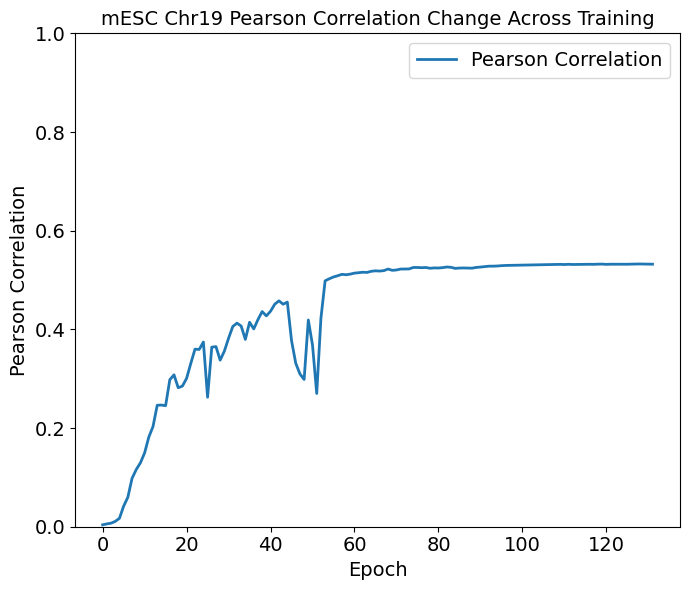

In [104]:
def plot_pearson_corr_across_epochs(df):
    fig = plt.figure(figsize=(7, 6))
    plt.plot(df.index, df["Pearson"], linewidth=2, label="Pearson Correlation")

    plt.title("mESC Chr19 Pearson Correlation Change Across Training", fontsize=14)
    plt.ylim((0,1))
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Pearson Correlation", fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    return fig

fig = plot_pearson_corr_across_epochs(training_log_df)
fig.savefig(os.path.join(TEST_DIR, "eval_results_pearson_corr.png"), dpi=300)
fig.show()

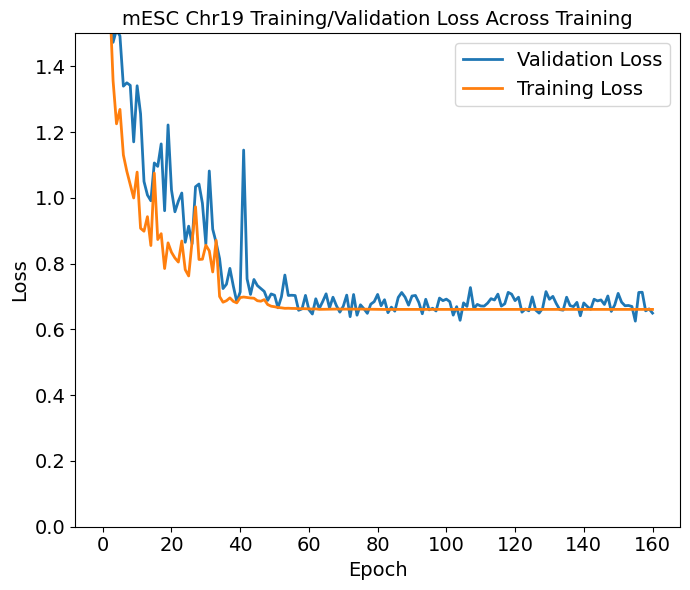

In [89]:
def plot_train_val_loss(df):
    fig = plt.figure(figsize=(7, 6))
    plt.plot(df.index, df["Train Loss"], linewidth=2, label="Validation Loss")
    plt.plot(df.index, df["Val Loss"], linewidth=2, label="Training Loss")

    plt.title("mESC Chr19 Training/Validation Loss Across Training", fontsize=14)
    plt.ylim((0,1.5))
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    return fig
    
fig = plot_train_val_loss(training_log_df)
fig.savefig(os.path.join(TEST_DIR, "eval_results_training_loss.png"), dpi=300)
fig.show()

In [90]:
tf_imp_dir = os.path.join(TEST_DIR, "tf_gradient_attributions")
            
tf_importance_df = pd.read_csv(os.path.join(tf_imp_dir, "tf_importance_matrix_exp.csv"), header=0, index_col=0)

fig = plt.figure(figsize=(10,8))

selected_tf_row = tf_importance_df.loc["Amyb"]
selected_tf_row = selected_tf_row.iloc[:50].sort_values(ascending=False)

plt.xticks(rotation=90, fontsize=10)
plt.bar(x=selected_tf_row.index, height=selected_tf_row)


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/transformer_testing_output/mESC/chr19/model_training_01_10_15_15_36/tf_gradient_attributions/tf_importance_matrix_exp.csv'